In [38]:
image_path=r'G:\UIBE科研\红外成像\InfraData\datasets\flir_data\1\optical'+'/FLIR_20220323_012820.jpg'

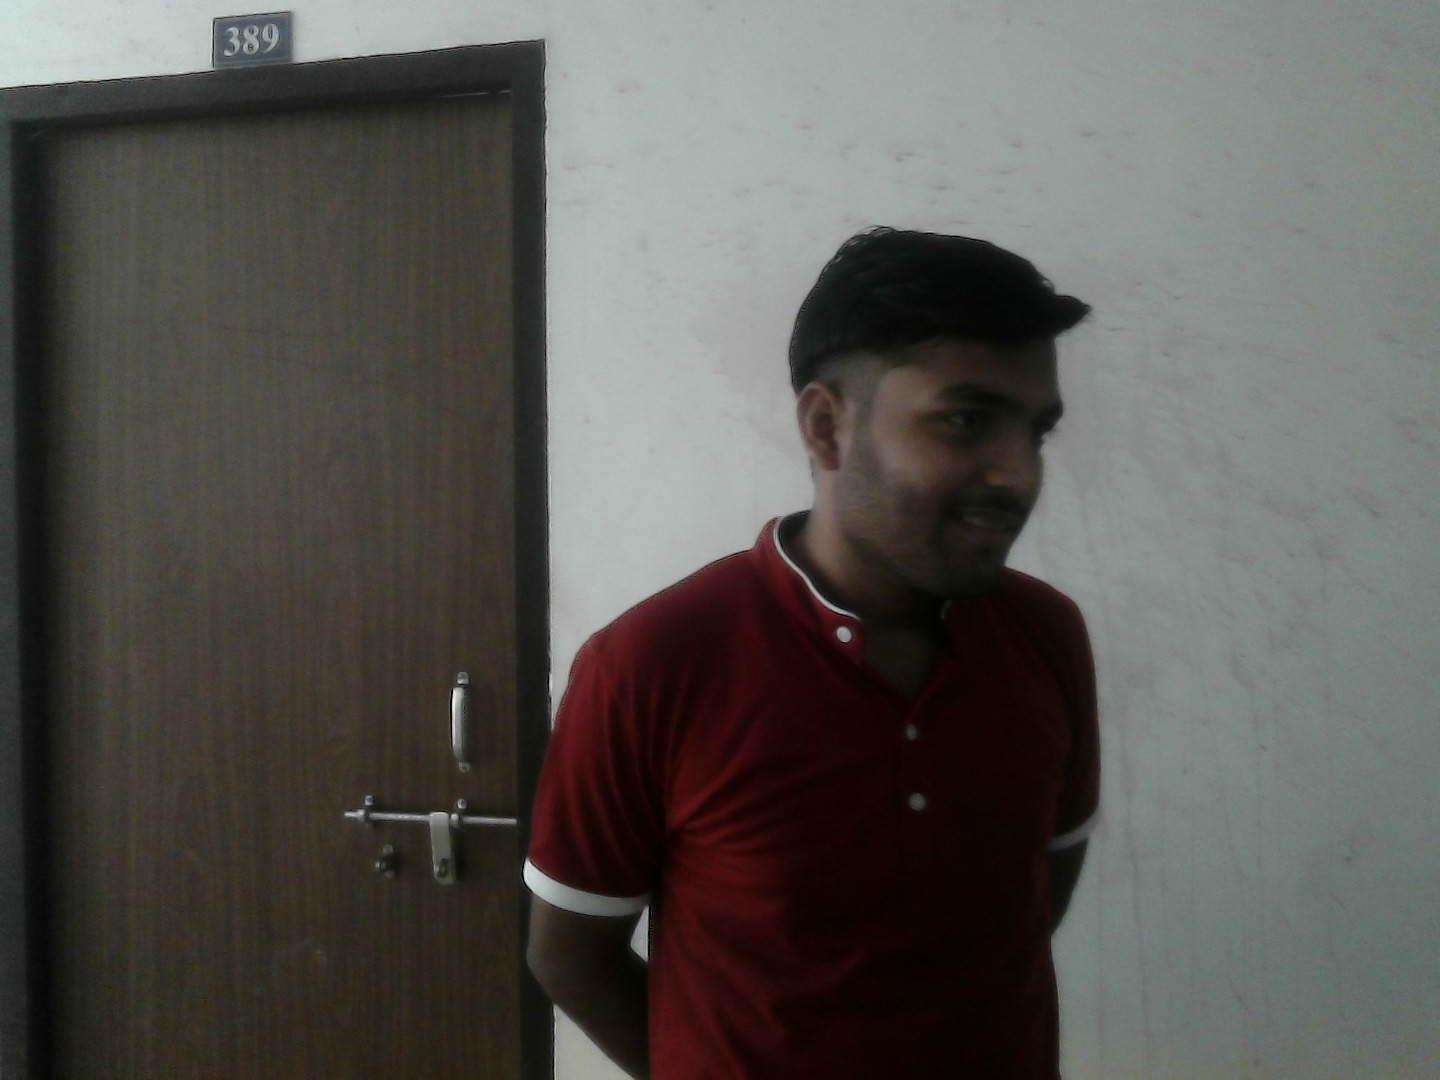

In [39]:
from IPython.display import Image, display,display_jpeg
display(Image(image_path,width='20%'))

792 1091


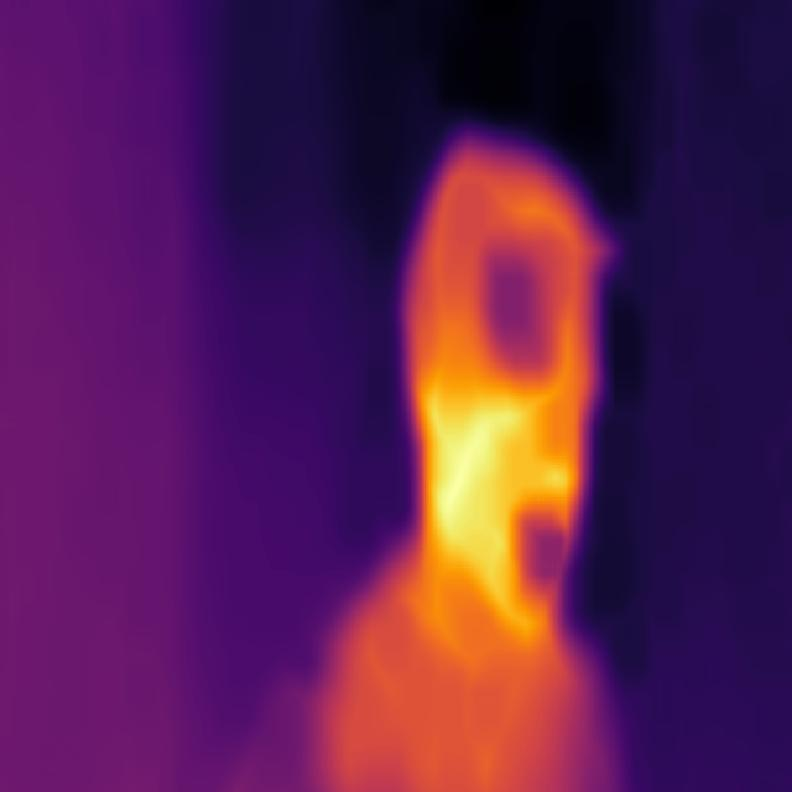

In [41]:
# test cropping images
thermal_path=r'G:\UIBE科研\红外成像\InfraData\datasets\flir_data_with_face\FLIR_20220323_012820.jpg'
from PIL import Image
img = Image.open(thermal_path) ## 打开chess.png文件，并赋值给img
print(img.width,img.height)
region = img.crop((0,0,792,792))## 0,0表示要裁剪的位置的左上角坐标，50,50表示右下角。
display(region,raw=False)


In [10]:
%pip install IRT-AI -U

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [42]:
# MediaPipe detection

# test an example
from tiai.mediapip.face import detect_face

image_path='datasets/test_data/head1.png'

img,list_node,list_connection=detect_face(image_path=image_path,save_detect_path=None,show=False)
print(len(list_node))



matrix:  384 288
shape:  1833 1353
box:  xmin: 0.2989330291748047
ymin: 0.27762049436569214
width: 0.4336931109428406
height: 0.5874648094177246

noise tip:  0.4920085668563843 0.5784764289855957
score:  [0.7801202535629272]
cx=187,cy=165
cx=230,cy=127
cx=158,cy=123
cx=272,cy=146
cx=124,cy=137
cx=187,cy=202
1


In [12]:
# read temperature data from csv file
def read_infrared_data(file):
  lines = open(file, "r", encoding='utf-8')
  data = []
  for line in lines:
    vs = line.strip().split(",")
    row = [float(v) for v in vs]
    data.append(row)
  return data

# find tempeature info based on the points
def find_temp(csv_matrix, image_x, image_y, image_width, image_height):
  m_width = len(csv_matrix[0])
  m_height = len(csv_matrix)
  rate1 = m_width * 1.0 / image_width
  rate2 = m_height * 1.0 / image_height
  c_x = int(image_x * rate1) - 1
  c_y = int(image_y * rate2) - 1
  if c_x < 0:
    c_x = 0
  if c_y < 0:
    c_y = 0
  if c_x > m_width - 1:
    c_x = m_width - 1
  if c_y > m_height - 1:
    c_y = m_height - 1
  # print(f"cx={c_x},cy={c_y}")
  return csv_matrix[c_y][c_x], c_x, c_y


In [13]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

%matplotlib inline

root_path='datasets/flir_data/1'
person_id='FLIR_20220309_035147'
optical_path=os.path.join(root_path,"optical/"+person_id+".jpg")
csv_path=os.path.join(root_path,"csv/"+person_id+".csv")
thermal_path=os.path.join(root_path,"thermal/"+person_id+".csv")

# mediapip
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# a function to get fact bounding and key face landmarks from the image
def GetFaceInfo(optical_path,csv_path):
    count=0
    list_node=[]
    with mp_face_detection.FaceDetection(
        model_selection=0, min_detection_confidence=0.5) as face_detection:
        
            image = cv2.imread(optical_path)
            img_matrix = read_infrared_data(csv_path)
            # print("matrix: ", len(img_matrix[0]), len(img_matrix))
            # print("shape: ",image.shape)
            image_height, image_width, _ = image.shape
            # print("shape: ", image_width, image_height)
            # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
            results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            # Draw face detections of each face.
            if not results.detections:
                # print("Not found!")
                return None
            annotated_image = image.copy()
            for detection in results.detections:
                # print(detection)
                # ('Nose tip:')
                # print(mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.NOSE_TIP))
                nose_tip=mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.NOSE_TIP)
                left_eye=mp_face_detection.get_key_point(detection,mp_face_detection.FaceKeyPoint.LEFT_EYE)
                right_eye = mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.RIGHT_EYE)
                left_ear_tragion = mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.LEFT_EAR_TRAGION)
                right_ear_tragion = mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.RIGHT_EAR_TRAGION)
                mouth_center = mp_face_detection.get_key_point(detection, mp_face_detection.FaceKeyPoint.MOUTH_CENTER)
                # bounding_box=detection.relative_bounding_box
                box=detection.location_data.relative_bounding_box
                score=detection.score
                # print("box: ",box)
                # print("noise tip: ",nose_tip.x, nose_tip.y)
                # print("score: ",score)
                def convert_m_xy(d):
                    x = d.x * image_width
                    y = d.y * image_height
                    temp, c_x, c_y = find_temp(img_matrix, x, y, image_width, image_height)
                    return (c_x,c_y,temp)
                model={
                    "id":f"face-{count}",
                    "score":score,
                    "box": (int(box.xmin * image_width),int(box.ymin*image_height),int(box.width*image_width),int(box.height*image_height)),
                    "nose_tip":convert_m_xy(nose_tip),
                    "left_eye": convert_m_xy(left_eye),
                    "right_eye": convert_m_xy(right_eye),
                    "left_ear_tragion": convert_m_xy(left_ear_tragion),
                    "right_ear_tragion": convert_m_xy(right_ear_tragion),
                    "mouth_center":convert_m_xy(mouth_center)
                }
                list_node.append(model)
                count+=1

                mp_drawing.draw_detection(annotated_image, detection)
            # cv2.imshow('annotated',annotated_image)
            # plt.show(annotated_image)
            # cv2.waitKey()
    return list_node

    


[{'id': 'face-0', 'score': [0.6904988288879395], 'box': (506, 457, 193, 193), 'nose_tip': (256, 244, 32.227900722786444), 'left_eye': (279, 229, 32.636967931236825), 'right_eye': (249, 225, 32.593979875233174), 'left_ear_tragion': (305, 240, 32.200934877534394), 'right_ear_tragion': (237, 230, 32.227900722786444), 'mouth_center': (255, 261, 32.27103228474948)}]


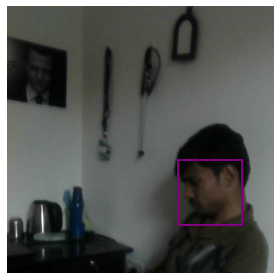

In [28]:
# An example to get face info using optical image and temperature's csv file
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import matplotlib.patches as mpatches

from PIL import Image
def crop_image(image_path):
    #cropping images
    img = Image.open(image_path) ## 打开chess.png文件，并赋值给img
    region = img.crop((0,0,792,792))## 0,0表示要裁剪的位置的左上角坐标，50,50表示右下角。
    # region_resized=region.resize((64,64))
    return region


optical_path=r'datasets\flir_data\1\optical'+'/FLIR_20220323_013117.jpg'
csv_path=r'datasets\flir_data\1\csv'+'/FLIR_20220323_013117.csv'

result=GetFaceInfo(optical_path=optical_path,csv_path=csv_path)
print(result)
bbox=result[0]['box']

c_image=crop_image(optical_path)

plt.imshow(c_image)

left, bottom, width, height = bbox
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="purple",
                       linewidth=2)
plt.axis("off")
plt.tight_layout()
plt.gca().add_patch(rect)


In [21]:
img=cv2.imread(optical_path)
x,y,w,h=bbox
# display(img)

cv2.rectangle(img, (int(x-w), int(y-h)), (int(x), int(y)), 1, -1)



array([[[ 24,  24,  24],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [233, 243, 230],
        [233, 243, 230],
        [233, 243, 230]],

       [[ 24,  24,  24],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [233, 243, 230],
        [233, 243, 230],
        [233, 243, 230]],

       [[ 24,  24,  24],
        [ 24,  24,  24],
        [ 24,  24,  24],
        ...,
        [233, 243, 230],
        [233, 243, 230],
        [233, 243, 230]],

       ...,

       [[ 60,  60,  60],
        [ 60,  60,  60],
        [ 61,  61,  61],
        ...,
        [117, 130, 128],
        [117, 130, 128],
        [117, 130, 128]],

       [[ 58,  58,  58],
        [ 58,  58,  58],
        [ 59,  59,  59],
        ...,
        [117, 130, 128],
        [117, 130, 128],
        [117, 130, 128]],

       [[ 57,  57,  57],
        [ 57,  57,  57],
        [ 57,  57,  57],
        ...,
        [118, 131, 129],
        [118, 131, 129],
        [118, 131, 129]]

In [ ]:
# Create a datasets
from tqdm import tqdm
import os
from quickcsv.file import *
import shutil


dataset_root_path='datasets/flir_data'

list_filenames_optical=[]
list_filenames_csv=[]
list_file_ids=[]
list_filenames_thermal=[]
for category in os.listdir(dataset_root_path):
    for file in os.listdir(os.path.join(dataset_root_path,category,'optical')):
        name, ext = os.path.splitext(file)
        optical_path=os.path.join(dataset_root_path,category,'optical',file)
        csv_path=os.path.join(dataset_root_path,category,'csv',name+".csv")
        thermal_path=os.path.join(dataset_root_path,category,'thermal',name+".jpg")
        
        # print(optical_path)
        if os.path.exists(optical_path) and os.path.exists(csv_path):
            list_filenames_optical.append(optical_path)
            list_filenames_csv.append(csv_path)
            list_filenames_thermal.append(thermal_path)
            list_file_ids.append(name)

print("Number of files: ",len(list_file_ids))

total_count=0
list_result=[]
for idx, name in tqdm(enumerate(list_file_ids)):
    info=GetFaceInfo(list_filenames_optical[idx],list_filenames_csv[idx])
    if info!=None:
        bounding_box=info[0]['box']
        # print(name,bounding_box)
        # print()
        total_count+=1
        list_result.append({
            "name":name,
            "x1":bounding_box[0],
            "y1":bounding_box[1],
            "w":bounding_box[2],
            "h":bounding_box[3],
            "label":'face'
        })
        target_path=f'datasets/flir_data_with_face/{name}.jpg'
        if os.path.exists(target_path):
            raise Exception('Should not have the existing files!')
        else:
            shutil.copy(list_filenames_thermal[idx],target_path)

print("Total no.: ",total_count)

write_csv('datasets/test_data/list_flir_data_with_face.csv',list_result)



Number of files:  467


467it [01:37,  4.81it/s]

Total no.:  120
Write CSV: ['name', 'x1', 'y1', 'w', 'h', 'label']  -> (datasets/test_data/list_flir_data_with_face.csv)


In [43]:
# raw image
from tqdm import tqdm
from PIL import Image
import os
import shutil

root_path='datasets/flir_data_with_face'

def crop_image_optical(image_path,save_path):
    #cropping images
    img = Image.open(image_path) ## 打开chess.png文件，并赋值给img
    region = img.crop((144,175,792+144,1091+175))## 0,0表示要裁剪的位置的左上角坐标，50,50表示右下角。
    region = region.resize((1080,1440))
    # region_resized=region.resize((64,64))
    # cropped_image=crop_image(optical_path)
    region.save(save_path)
    return region

root_path='datasets/flir_data_with_face'
for file in tqdm(os.listdir(root_path)):
    filename,ext=os.path.splitext(file)
    file1=f'datasets/flir_data/1/optical/{filename}.jpg'
    file2=f'datasets/flir_data/2/optical/{filename}.jpg'
    file3=f'datasets/flir_data/3/optical/{filename}.jpg'
    # print(file1)
    if os.path.exists(file1):
        shutil.copy(file1,f'datasets/flir_data_raw/{filename}.jpg')
        crop_image_optical(f'datasets/flir_data_raw/{filename}.jpg',f'datasets/flir_data_raw/{filename}.jpg')
    if os.path.exists(file2):
        shutil.copy(file2,f'datasets/flir_data_raw/{filename}.jpg')
        crop_image_optical(f'datasets/flir_data_raw/{filename}.jpg',f'datasets/flir_data_raw/{filename}.jpg')
    if os.path.exists(file3):
            shutil.copy(file3,f'datasets/flir_data_raw/{filename}.jpg')
            crop_image_optical(f'datasets/flir_data_raw/{filename}.jpg',f'datasets/flir_data_raw/{filename}.jpg')

100%|██████████| 120/120 [00:05<00:00, 23.28it/s]


In [ ]:

from PIL import Image
def crop_image(image_path):
    #cropping images
    img = Image.open(image_path) ## 打开chess.png文件，并赋值给img
    region = img.crop((0,0,792,792))## 0,0表示要裁剪的位置的左上角坐标，50,50表示右下角。
    # region_resized=region.resize((64,64))
    return region


root_path='datasets/flir_data_with_face'
target_path='datasets/flir_data_with_face_resized'
for file in tqdm(os.listdir(root_path)):
    file1=os.path.join(root_path,file)
    file2=os.path.join(target_path,file)
    r=crop_image(file1)
    r.save(file2)

100%|██████████| 120/120 [00:02<00:00, 51.96it/s]
